In [52]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from skimage.io import ImageCollection
from skimage.data import imread
from skimage.color import rgb2hsv, rgb2gray
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage.feature import (ORB, match_descriptors, corner_harris,
                             plot_matches)
from skimage.measure import ransac
from numpy.random import randint

from sklearn.feature_extraction import image
%matplotlib inline

In [53]:
def hsv_imread(img_path):
    return rgb2hsv(imread(img_path))

def gray_imread(img_path):
    return rgb2gray(imread(img_path))

def load_images(search_dir, ftype):
    search_path = os.path.join(search_dir, '*'+ftype)
    imgs = ImageCollection(search_path, conserve_memory=False,
                           load_func=gray_imread)
    return imgs

In [54]:
pano_imgs = ImageCollection('*.jpg')
img_col = load_images('../data/jpg/', 'jpg')[:50]
img_feat = {}
num_imgs = len(img_col)
min_matches = 40
num_keypoints = 800

In [55]:
def compare(*images, **kwargs):
    """
    Function to display images side by side (from skimage example)

    Parameters
    ----------
    image0, image1, ....: ndarray
        Images to display
    labels: list
        Labels for the different images
    """
    f, ax = plt.subplots(1, len(images), **kwargs)
    ax = np.array(ax, ndmin=1)

    labels = kwargs.pop('labels', None)
    labels = [''] * len(images)
    for n, (image, label) in enumerate(zip(images, labels)):
        ax[n].imshow(image, interpolation='nearest', cmap=plt.gray())
        ax[n].set_title(label)
        #ax[n].axis('off')
    plt.tight_layout()

In [56]:
def get_best_matches(k1, k2, matches):
    src = k1[matches[:,0]][:,::-1]
    dst = k2[matches[:,1]][:,::-1]
    # if there are not enough matches, this fails
    model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                                   min_samples=20, residual_threshold=1,
                                   max_trials=40)

    return model_robust, inliers

def develop_metadata_mosaic():
    # set max pitch and roll angles as qulity
    pass

In [57]:



def plot_two_matches(img1, img2, k1, k2, matches):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.gray()
    #plot_matches(ax, img1, img2, k1, k2, matches)
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].scatter(k1[:, 1], k1[:, 0],  facecolors='none', edgecolors='r')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].scatter(k2[:, 1], k2[:, 0], facecolors='none', edgecolors='r')
    plt.show()
    
    plt.show()
    
def plot_two_keypoints(img1, img2, k1, k2, s1=1, s2=1):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.gray()

    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].scatter(k1[:, 1], k1[:, 0], facecolors='none', edgecolors='r')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].scatter(k2[:, 1], k2[:, 0], facecolors='none', edgecolors='r')
    plt.show()

In [224]:
def find_mask(base_img, img, model_robust):
    # left to right produces extra black space
    
    output_shape, corner_min = find_output_shape(base_img, model_robust)
    print("output_shape", output_shape, corner_min)
    #print(model_robust.scale, model_robust.translation, model_robust.rotation)
    
    # This in-plane offset is the only necessary transformation for the base image
    offset = SimilarityTransform(translation= -corner_min)
    base_warped = warp(base_img, offset.inverse, order=3, 
                      output_shape = output_shape, cval=-1)
    
    # warp image corners to new position in mosaic
    transform = (model_robust + offset).inverse
    
    img_warped = warp(img, transform, order=3, 
                      output_shape=output_shape, cval=-1)
    
    base_mask = (base_warped != -1)
    base_warped[~base_mask] = 0

    img_mask = (img_warped != -1)
    img_warped[~img_mask] = 0
    
    #print('base', base_img.shape, base_warped.shape)
    #print('img', img.shape, img_warped.shape)
    #compare(base_img, base_warped, base_mask)
    #compare(img, img_warped, img_mask)
    
    #plt.show()
    # Add the three images together. This could create dtype overflows!
    # We know they are are floating point images after warping, so it's OK.
    merged = (base_warped + img_warped)

    # Track the overlap by adding the masks together
    overlap = (base_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
               img_mask)

    # Normalize through division by `overlap` - but ensure the minimum is 1
    norm = merged / np.maximum(overlap, 1)
    norm1 = remove_empty_edges(norm)
    
    return norm1
    

In [225]:
def detect_and_extract(detector, img):
    detector.detect_and_extract(img)
    keypoints = detector.keypoints
    descriptors = detector.descriptors
    return keypoints, descriptors

In [226]:
def find_output_shape(base_img, model_robust):
    r, c = base_img.shape[:2]
    
    corners = np.array([[0,0], 
                        [0,r],
                        [c,0],
                        [c,r]])
    
    warped_corners = model_robust(corners)
    all_corners = np.vstack((warped_corners, corners))
    # The overally output shape will be max - min
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    # Ensure integer shape with np.ceil and dtype conversion
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    return output_shape, corner_min


In [227]:
def find_two_matches(base_img, img, base_k, img_k, base_d, img_d, min_matches=10):
    #matches = match_descriptors(d1, d2, max_distance=.2, cross_check=True)
    matches = match_descriptors(base_d, img_d, cross_check=True)
    
    #   * src (image to be registered): pano2
    #   * dst (reference image): pano1, our middle frame registration target
    src = img_k[matches[:,1]][:,::-1]
    dst = base_k[matches[:,0]][:,::-1]
    
    #compare(base_img, img)
    # if there are not enough matches, this fails
    if matches.shape[0] > min_matches:
        model_robust, inliers = ransac((src, dst), AffineTransform,
                                   min_samples=4, residual_threshold=1,
                                   max_trials=300)

        ransac_matches = matches[inliers]
        return model_robust, ransac_matches
    else:
        return np.zeros((0, 2)), np.zeros((0, 2))

In [228]:
sums = [1,0,0,0]

 

In [230]:
def remove_empty_edges(img):
    def get_mask(sums):
        if sum(sums) > 0:
            first = sums.index(1)
            last = sums[::-1].index(1)

            num_ones = (len(sums)-first)-last
            out = [0]*first + [1]*num_ones + [0]*last
            return out
        else:
            return sums
    
    #for ax in range(len(img.shape)):
    axes = [0, 1]
    for ax in range(2):
        sums = np.sum(img, axis=axes[ax])
        # make a mask of zero lines in image 
        sums= [bool(x) for x in sums]
        empty = get_mask(list(sums)) 
        img = np.compress(empty, img, axis=axes[ax-1])
    return img

In [221]:
def find_all_matches(base_img, imgs, 
                     last_num_unmatched, 
                     num_keypoints=800,
                     min_to_match=10):
    not_matched = []
    print("=====================================")
    
    for xx, img in enumerate(imgs):
        print('working on xx', xx)
        orb = ORB(n_keypoints=num_keypoints, fast_threshold=0.05)
        base_k, base_d = detect_and_extract(orb, base_img)
        img_k, img_d = detect_and_extract(orb, img)
        matches = match_descriptors(base_d, img_d, cross_check=True)
        
        model_robust, ransac_matches = find_two_matches(base_img, img, 
                                                            base_k, img_k, 
                                                            base_d, img_d)
        #fig, ax = plt.subplots(1,1,figsize=(15,12))
        #plot_matches(ax, base_img, img, base_k, img_k, matches)
        if ransac_matches.shape[0] < min_to_match:
            #print("not matched ransac shape", ransac_matches.shape[0])
            not_matched.append(img) 
        else:
            #print('ransac matches', ransac_matches.shape)
            base_img = find_mask(base_img, img, model_robust) 
            print("FINISHED with find_mask")
    # if we were able to match some images to this base_img that
    # were not matched in the last run, call again until 
    # the number of unmatched images stops decreasing
    
    print('num previous unmatched', last_num_unmatched)
    print("could not imgs %s out of %s" %(len(not_matched), len(imgs)))
    # not_matched must be > 0
    # the new number of matches must be less than last time's not matched
    if (len(not_matched)) > 0:
        if len(not_matched) < last_num_unmatched:
            return find_all_matches(base_img, not_matched, len(not_matched))
    
    print("OUT not_matched, imgs", len(not_matched), len(imgs))
    return base_img, not_matched
    

In [222]:
def patchmaker(img):
    patches = image.extract_patches_2d(img, patch_size=(100,100),
                                         max_patches=10,
                                         random_state=182)
    return patches

(320, 480)
working on xx 0
output_shape [320 481] [ -5.68434189e-14   0.00000000e+00]
FINISHED with find_mask
working on xx 1
output_shape [333 529] [ 0.  0.]
FINISHED with find_mask
working on xx 2
output_shape [347 626] [ 0.  0.]
FINISHED with find_mask
working on xx 3
output_shape [363 722] [ 0.  0.]
FINISHED with find_mask
num previous unmatched 4
could not imgs 0 out of 4
OUT not_matched, imgs 0 4


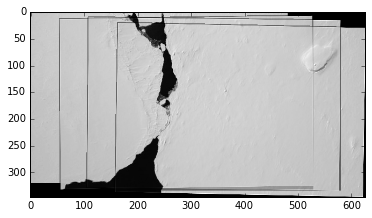

In [231]:
#patches = patchmaker(img_col[0])
base_img = img_col[0]
print(base_img.shape)
timg_col = img_col[:4]
dbase_img, dimgs = find_all_matches(base_img, timg_col, len(timg_col))
plt.figure()
plt.imshow(dbase_img)
plt.show()

In [216]:
t1 = (0,-150)
t2 = (-150,-300)
t3 = (0, 200)
t4 = (150, 0)
t5 = (300, 300)
base_img = rgb2gray(pano_imgs[0])
imgs = []
ts = [t1, t2, t2, t4, t5]

#for tt in ts:
#    tform = SimilarityTransform(translation=tt)
#    imgs.append(warp(base_img, tform))

#dbase_img, dimgs = find_all_matches(base_img, imgs, len(imgs), 50)
#plt.figure()
#plt.imshow(dbase_img)
#plt.show()


RUNNING BASE X 0
working on xx 0
477 720
working on xx 1
507 1120
num previous unmatched 2
could not imgs 0 out of 2
OUT not_matched, imgs 0 2
finished with 0 unmatched


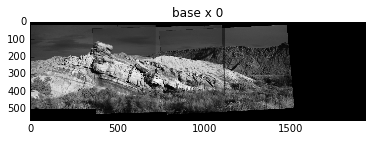

RUNNING BASE X 0
working on xx 0
477 720
working on xx 1
498 1088
num previous unmatched 2
could not imgs 0 out of 2
OUT not_matched, imgs 0 2
finished with 0 unmatched


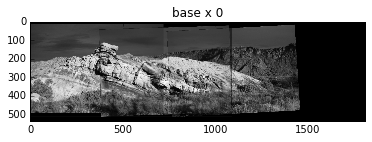

RUNNING BASE X 2
working on xx 0
working on xx 1
477 720
num previous unmatched 2
could not imgs 1 out of 2
working on xx 0
512 1119
num previous unmatched 1
could not imgs 0 out of 1
OUT not_matched, imgs 0 1
finished with 0 unmatched


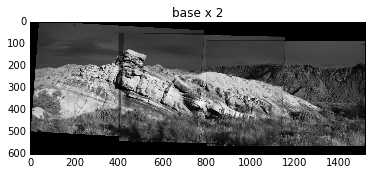

RUNNING BASE X 1
working on xx 0
477 720
working on xx 1
516 1111
num previous unmatched 2
could not imgs 0 out of 2
OUT not_matched, imgs 0 2
finished with 0 unmatched


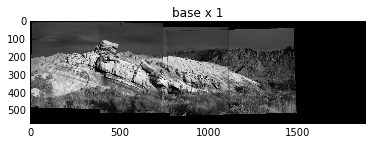

In [66]:
#run through each of the images starting randomly

for x in range(4):
    imgs = [rgb2gray(pano_imgs[0]), rgb2gray(pano_imgs[1]), rgb2gray(pano_imgs[2])]
    base_x = randint(0, len(imgs))
    base_img = imgs.pop(base_x)
    print("RUNNING BASE X", base_x)
    dbase_img, dimgs = find_all_matches(base_img, imgs, len(imgs))

    
    # if there are still images left over, use these to 
    # start a new base image
    print('finished with %s unmatched' %len(dimgs))

    plt.figure()
    plt.title('base x %s' %base_x)
    plt.imshow(dbase_img)
    plt.show()


In [67]:



    

    

## Match descriptors between left/right images and the center
#matches10 = match_descriptors(base_d, d0, cross_check=True)

#matches12 = match_descriptors(base_d, d2, cross_check=True)

#model_robust10, ransac_matches10 = find_two_matches(base_img, img0, base_k, k0, base_d, d0)
#model_robust12, ransac_matches12 = find_two_matches(base_img, img2, base_k, k2, base_d, d2)

#nn0 = find_mask(base_img, img0, model_robust10)
#plt.show()
#nn2 = find_mask(base_img, img2, model_robust12)
#plt.show()
#fig, ax = plt.subplots(1,1,figsize=(15,12))
#plot_matches(ax, base_img, img2, base_k, k2, ransac_matches)

